In [2]:
import os
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [3]:
np.random.seed(42)
random.seed(42)
data = pd.read_excel('/content/RFLFSODataFull.xlsx')
data = shuffle(data, random_state=42)

In [4]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [5]:
train_data.columns

Index(['FSO_Att', 'RFL_Att', 'AbsoluteHumidity', 'AbsoluteHumidityMax',
       'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate',
       'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax',
       'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature',
       'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time',
       'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection',
       'WindSpeed', 'WindSpeedMax', 'WindSpeedMin'],
      dtype='object')

In [ ]:

def feature_selection(data, target_col, drop_col, min_features=1):
    if drop_col in data.columns:
        data = data.drop(columns=[drop_col])

    y = data[target_col]
    X = data.drop(columns=[target_col])

    results = []
    remaining_features = list(X.columns)
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    while len(remaining_features) >= min_features:
        model.fit(X[remaining_features], y)
        y_pred = model.predict(X[remaining_features])

        rmse = mean_squared_error(y, y_pred) ** 0.5
        r2 = r2_score(y, y_pred)

        print(f"Remaining features: {remaining_features}")
        print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

        results.append({'Remaining_Features': remaining_features.copy(), 'RMSE': rmse, 'R2': r2})

        if len(remaining_features) == min_features:
            break


        feature_importances = model.feature_importances_
        least_important_feature = remaining_features[np.argmin(feature_importances)]
        print(f"Removing feature: {least_important_feature}")
        remaining_features.remove(least_important_feature)

    return pd.DataFrame(results)

results_fso = feature_selection(train_data, target_col='FSO_Att', drop_col='RFL_Att')
results_rf = feature_selection(train_data, target_col='RFL_Att', drop_col='FSO_Att')


Remaining features: ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection', 'WindSpeed', 'WindSpeedMax', 'WindSpeedMin']
RMSE: 0.3136, R²: 0.9936
Removing feature: Frequency
Remaining features: ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection', 'WindSpeed', 'WindSpeedMax', 'WindSpeedMin']
RMSE: 0.3135, R²: 0.9936
Removing feature: RainIntensityMax
Remain

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

def removed_features_plot(results, target_name, save=False, save_dir='plots'):
    if results.empty or 'Remaining_Features' not in results.columns:
        print("Results DataFrame is empty or malformed.")
        return

    removed_features = [
        list(set(results.iloc[i]['Remaining_Features']) - set(results.iloc[i + 1]['Remaining_Features']))[0]
        if set(results.iloc[i]['Remaining_Features']) - set(results.iloc[i + 1]['Remaining_Features'])
        else results.iloc[i]['Remaining_Features'][0]
        for i in range(len(results) - 1)
    ] + [results.iloc[-1]['Remaining_Features'][0]]

    rmse_values = results['RMSE'].values
    r2_values = results['R2'].values

    fig, ax1 = plt.subplots(figsize=(12, 6))

    step = max(1, len(removed_features) // 20)
    ax1.set_xlabel('Removed Features')
    ax1.set_ylabel('RMSE', color='tab:blue')
    ax1.plot(removed_features[::step], rmse_values[::step], marker='o', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='tab:orange')
    ax2.plot(removed_features[::step], r2_values[::step], marker='s', linestyle='--', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    ax1.set_xticks(range(0, len(removed_features), step))
    ax1.set_xticklabels(removed_features[::step], rotation=90)

    diff_rmse = np.diff(rmse_values)
    threshold = 0.05
    split_index = np.where(diff_rmse > threshold)[0][0] if np.any(diff_rmse > threshold) else len(removed_features) // 2
    ax1.axvline(x=split_index, color='green', linestyle='dotted', linewidth=2)

    plt.title(f'Feature Removal vs RMSE & R² for {target_name} ')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    if save:
        os.makedirs(save_dir, exist_ok=True)
        file_path = os.path.join(save_dir, f"{target_name.replace(' ', '_')}_feature_selection_plot.png")
        plt.savefig(file_path, bbox_inches='tight')
        print(f" Plot saved to: {file_path}")

    plt.show()


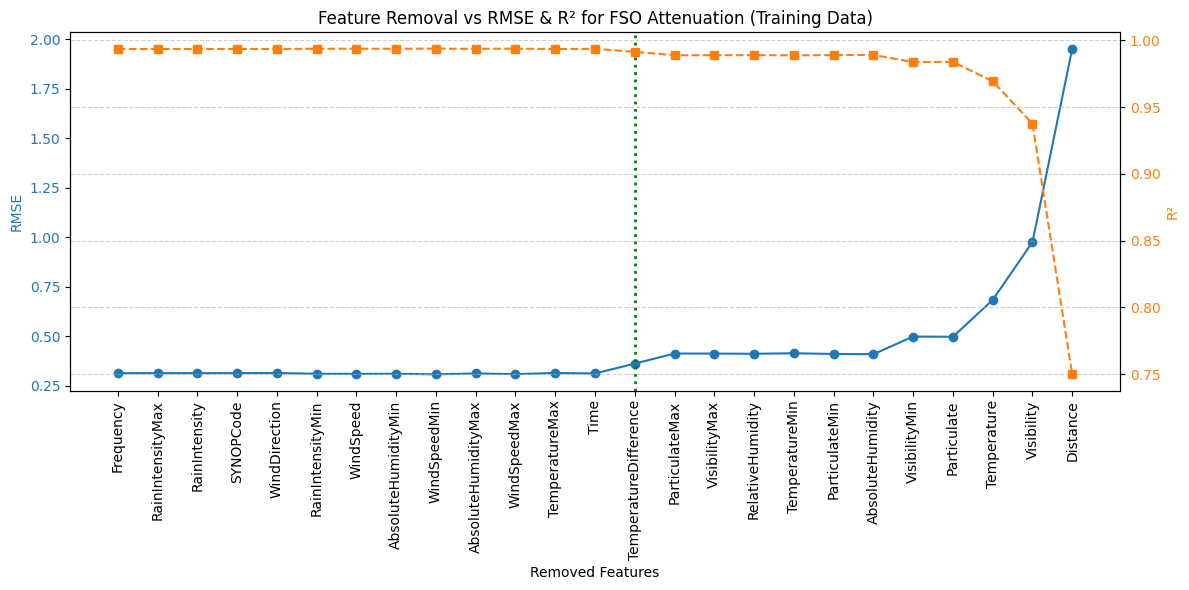

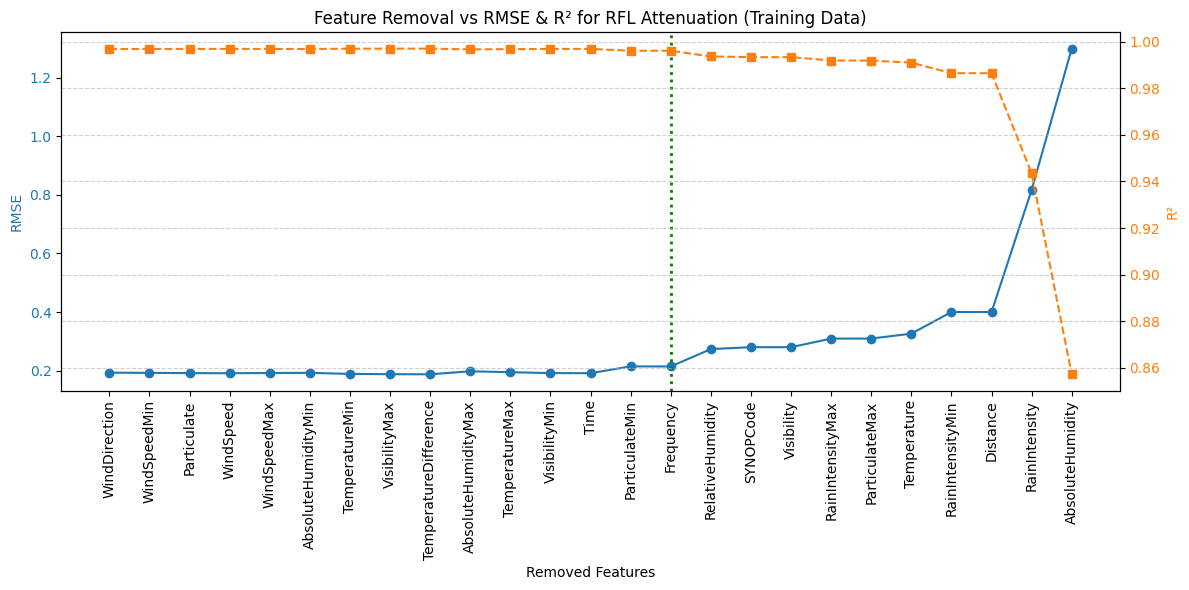

In [ ]:
removed_features_plot(results_fso.head(100), "FSO Attenuation", save=False)
removed_features_plot(results_rf.head(100), "RFL Attenuation", save=False)

In [ ]:
split_index_fso = np.where(np.diff(results_fso['RMSE']) > 0.05)[0][0] if np.any(np.diff(results_fso['RMSE']) > 0.05) else len(results_fso) // 2
split_index_rf = np.where(np.diff(results_rf['RMSE']) > 0.05)[0][0] if np.any(np.diff(results_rf['RMSE']) > 0.05) else len(results_rf) // 2

remaining_features_fso = results_fso.iloc[split_index_fso]['Remaining_Features']
remaining_features_rf = results_rf.iloc[split_index_rf]['Remaining_Features']

num_features_to_retain = min(len(remaining_features_fso), len(remaining_features_rf))

data_FSO = remaining_features_fso[:num_features_to_retain]
data_RFL = remaining_features_rf[:num_features_to_retain]

print("Retained Important Features for FSO Attenuation:", data_FSO)
print("Retained Important Features for RFL Attenuation:", data_RFL)


Retained Important Features for FSO Attenuation: ['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'TemperatureMin', 'Visibility', 'VisibilityMax']
Retained Important Features for RFL Attenuation: ['AbsoluteHumidity', 'Distance', 'Frequency', 'ParticulateMax', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'Visibility']


In [6]:
data_FSO= train_data[['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'TemperatureMin', 'Visibility', 'VisibilityMax','SYNOPCode','FSO_Att']]

In [7]:
data_RFL=train_data[['AbsoluteHumidity', 'Distance', 'Frequency', 'ParticulateMax', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'Visibility','RFL_Att']]

## Converting synop code into categorical for FSO


In [8]:
data_FSO = data_FSO.copy()

synop_values = [0, 3, 4, 5, 6, 7, 8]

categories = ['clear', 'dust_storm', 'fog', 'drizzle', 'rain', 'snow', 'showers']

data_FSO['SYNOPCode_Categorical'] = pd.Categorical(

    data_FSO['SYNOPCode'],

    categories=synop_values,

    ordered=True

)

data_FSO['SYNOPCode_Categorical'] = data_FSO['SYNOPCode_Categorical'].map(

    dict(zip(synop_values, categories))

)
print(data_FSO[['SYNOPCode', 'SYNOPCode_Categorical']].head(7))

       SYNOPCode SYNOPCode_Categorical
1261           6                  rain
22916          4                   fog
8670           0                 clear
74811          0                 clear
28415          0                 clear
32527          0                 clear
50579          0                 clear


In [9]:
data_FSO.columns

Index(['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMax',
       'ParticulateMin', 'RelativeHumidity', 'Temperature',
       'TemperatureDifference', 'TemperatureMin', 'Visibility',
       'VisibilityMax', 'SYNOPCode', 'FSO_Att', 'SYNOPCode_Categorical'],
      dtype='object')

In [10]:
X = data_FSO[['SYNOPCode_Categorical','AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y = data_FSO[['FSO_Att']]

## One hot encoding as a part of pre-processing for FSO

In [11]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_features = encoder.fit_transform(X[['SYNOPCode_Categorical']])

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(['SYNOPCode_Categorical']),
    index=X.index
)

X = X.drop('SYNOPCode_Categorical', axis=1)
X = pd.concat([X, encoded_df], axis=1)


## Hyperparameter tunning for FSO
### Method 1 (Generic Method)
#### Random Search

In [12]:
X_fso_train = X
y_fso_train = y

In [13]:
X_fso_train.columns

Index(['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMax',
       'ParticulateMin', 'RelativeHumidity', 'Temperature',
       'TemperatureDifference', 'TemperatureMin', 'Visibility',
       'VisibilityMax', 'SYNOPCode_Categorical_drizzle',
       'SYNOPCode_Categorical_dust_storm', 'SYNOPCode_Categorical_fog',
       'SYNOPCode_Categorical_rain', 'SYNOPCode_Categorical_showers',
       'SYNOPCode_Categorical_snow'],
      dtype='object')

In [14]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': randint(100, 250),
    'max_features': ['sqrt', 'log2'],
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}
rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50,
                                   cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_fso_train, y_fso_train.values.ravel())

print(f"Best parameters from RandomizedSearchCV: {random_search.best_params_}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters from RandomizedSearchCV: {'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 223}


#### Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {

    'n_estimators': [random_search.best_params_['n_estimators'] - 50, random_search.best_params_['n_estimators'], random_search.best_params_['n_estimators'] + 50],
    'max_features': [random_search.best_params_['max_features']],
    'max_depth': [random_search.best_params_['max_depth'] - 5, random_search.best_params_['max_depth'], random_search.best_params_['max_depth'] + 5],
    'min_samples_split': [random_search.best_params_['min_samples_split']],
    'min_samples_leaf': [random_search.best_params_['min_samples_leaf']]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_fso_train, y_fso_train.values.ravel())

print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters from GridSearchCV: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 273}


#### Hybrid search

In [ ]:
best_params = grid_search.best_params_

best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_fso_train, y_fso_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=273,
                      random_state=42)

In [ ]:
test_data_FSO = test_data[['AbsoluteHumidity', 'Distance', 'Particulate', 'ParticulateMax', 'ParticulateMin',
                           'RelativeHumidity', 'Temperature', 'TemperatureDifference', 'TemperatureMin',
                           'Visibility', 'VisibilityMax', 'SYNOPCode', 'FSO_Att']].copy()

test_data_FSO['SYNOPCode_Categorical'] = pd.Categorical(
    test_data_FSO['SYNOPCode'],
    categories=synop_values,
    ordered=True
)

test_data_FSO['SYNOPCode_Categorical'] = test_data_FSO['SYNOPCode_Categorical'].map(
    dict(zip(synop_values, categories))
)

X_test = test_data_FSO.drop('FSO_Att', axis=1)
y_test = test_data_FSO['FSO_Att']

encoded_features_test = encoder.transform(X_test[['SYNOPCode_Categorical']])

encoded_df_test = pd.DataFrame(
    encoded_features_test,
    columns=encoder.get_feature_names_out(['SYNOPCode_Categorical']),
    index=X_test.index
)

X_test = X_test.drop('SYNOPCode_Categorical', axis=1)
X_test = pd.concat([X_test, encoded_df_test], axis=1)
X_test = X_test.drop('SYNOPCode', axis=1)

X_fso_test = X_test
y_fso_test = y_test


In [ ]:
y_test_pred = best_rf_model.predict(X_fso_test)
rmse = np.sqrt(mean_squared_error(y_fso_test, y_test_pred))
r2 = r2_score(y_fso_test, y_test_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Root Mean Squared Error (RMSE): 0.9737
R² Score: 0.9377



  ### Method 1 (Generic Method) for RFL


In [ ]:
X_RFL_train=data_RFL[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','SYNOPCode','Temperature','Visibility']]
y_RFL_train=data_RFL[['RFL_Att']]

In [ ]:
synop_values = [0, 3, 4, 5, 6, 7, 8]

categories = ['clear', 'dust_storm', 'fog', 'drizzle', 'rain', 'snow', 'showers']

X_RFL_train['SYNOPCode_Categorical'] = pd.Categorical(

    X_RFL_train['SYNOPCode'],

    categories=synop_values,

    ordered=True

)

X_RFL_train['SYNOPCode_Categorical'] = X_RFL_train['SYNOPCode_Categorical'].map(

    dict(zip(synop_values, categories))

)
print(X_RFL_train[['SYNOPCode', 'SYNOPCode_Categorical']].head(7))

       SYNOPCode SYNOPCode_Categorical
1261           6                  rain
22916          4                   fog
8670           0                 clear
74811          0                 clear
28415          0                 clear
32527          0                 clear
50579          0                 clear


In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_features = encoder.fit_transform(X_RFL_train[['SYNOPCode_Categorical']])

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(['SYNOPCode_Categorical']),
    index=X_RFL_train.index
)

X_RFL_train = X_RFL_train.drop('SYNOPCode_Categorical', axis=1)
X_RFL_train = pd.concat([X_RFL_train, encoded_df], axis=1)
X_RFL_train = X_RFL_train.drop('SYNOPCode', axis=1)

In [ ]:
X_RFL_train.columns

Index(['AbsoluteHumidity', 'Distance', 'Frequency', 'ParticulateMax',
       'RainIntensity', 'RainIntensityMax', 'RainIntensityMin',
       'RelativeHumidity', 'Temperature', 'Visibility',
       'SYNOPCode_Categorical_drizzle', 'SYNOPCode_Categorical_dust_storm',
       'SYNOPCode_Categorical_fog', 'SYNOPCode_Categorical_rain',
       'SYNOPCode_Categorical_showers', 'SYNOPCode_Categorical_snow'],
      dtype='object')

In [ ]:
test_data_RFL = test_data[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax',
                           'RainIntensityMin','RelativeHumidity','SYNOPCode','Temperature','Visibility','RFL_Att']].copy()

test_data_RFL['SYNOPCode_Categorical'] = pd.Categorical(
    test_data_RFL['SYNOPCode'],
    categories=synop_values,
    ordered=True
)

test_data_RFL['SYNOPCode_Categorical'] = test_data_RFL['SYNOPCode_Categorical'].map(
    dict(zip(synop_values, categories))
)

X_test = test_data_RFL.drop('RFL_Att', axis=1)
y_test = test_data_RFL['RFL_Att']

encoded_features_test = encoder.transform(X_test[['SYNOPCode_Categorical']])

encoded_df_test = pd.DataFrame(
    encoded_features_test,
    columns=encoder.get_feature_names_out(['SYNOPCode_Categorical']),
    index=X_test.index
)

X_test = X_test.drop('SYNOPCode_Categorical', axis=1)
X_test = pd.concat([X_test, encoded_df_test], axis=1)
X_test = X_test.drop('SYNOPCode', axis=1)

X_RFL_test = X_test
y_RFL_test = y_test

## Hyperparameter tunning for RFL
### Random search

In [ ]:
param_dist = {

    'n_estimators': randint(100, 250),

    'max_features': ['sqrt', 'log2'],

    'max_depth': randint(10, 30),

    'min_samples_split': randint(2, 10),

    'min_samples_leaf': randint(1, 10)

}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50,

                                   cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_RFL_train, y_RFL_train)

print(f"Best parameters from RandomizedSearchCV: {random_search.best_params_}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters from RandomizedSearchCV: {'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 170}


### Grid search

In [ ]:
param_grid = {

    'n_estimators': [random_search.best_params_['n_estimators'] - 50, random_search.best_params_['n_estimators'], random_search.best_params_['n_estimators'] + 50],
    'max_features': [random_search.best_params_['max_features']],
    'max_depth': [random_search.best_params_['max_depth'] - 5, random_search.best_params_['max_depth'], random_search.best_params_['max_depth'] + 5],
    'min_samples_split': [random_search.best_params_['min_samples_split']],
    'min_samples_leaf': [random_search.best_params_['min_samples_leaf']]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_RFL_train, y_RFL_train.values.ravel())

print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters from GridSearchCV: {'max_depth': 27, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 220}


### Hybrid search

In [ ]:
best_params = grid_search.best_params_

best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_RFL_train, y_RFL_train)

y_test_pred = best_rf_model.predict(X_RFL_test)
rmse = np.sqrt(mean_squared_error(y_RFL_test, y_test_pred))
r2 = r2_score(y_RFL_test, y_test_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.5790
R² Score: 0.9716


# Method 2(Special Method)
## Grouping the data based on synopcode

In [ ]:
synop_groups = data_FSO.groupby('SYNOPCode')

for synop_code, group in synop_groups:

    filename = f"FSO_dataset_SYNOPCode_{synop_code}.csv"
    group.to_csv(filename, index=False)

    print(f"Dataset for SYNOPCode {synop_code} saved as {filename}.")

Dataset for SYNOPCode 0 saved as FSO_dataset_SYNOPCode_0.csv.
Dataset for SYNOPCode 3 saved as FSO_dataset_SYNOPCode_3.csv.
Dataset for SYNOPCode 4 saved as FSO_dataset_SYNOPCode_4.csv.
Dataset for SYNOPCode 5 saved as FSO_dataset_SYNOPCode_5.csv.
Dataset for SYNOPCode 6 saved as FSO_dataset_SYNOPCode_6.csv.
Dataset for SYNOPCode 7 saved as FSO_dataset_SYNOPCode_7.csv.
Dataset for SYNOPCode 8 saved as FSO_dataset_SYNOPCode_8.csv.


In [ ]:
df_0= pd.read_csv('/content/FSO_dataset_SYNOPCode_0.csv')
df_3= pd.read_csv('/content/FSO_dataset_SYNOPCode_3.csv')
df_4= pd.read_csv('/content/FSO_dataset_SYNOPCode_4.csv')
df_5= pd.read_csv('/content/FSO_dataset_SYNOPCode_5.csv')
df_6= pd.read_csv('/content/FSO_dataset_SYNOPCode_6.csv')
df_7= pd.read_csv('/content/FSO_dataset_SYNOPCode_7.csv')
df_8= pd.read_csv('/content/FSO_dataset_SYNOPCode_8.csv')

In [ ]:
synop_groups = data_RFL.groupby('SYNOPCode')

for synop_code, group in synop_groups:

    filename = f"RFL_dataset_SYNOPCode_{synop_code}.csv"
    group.to_csv(filename, index=False)

    print(f"Dataset for SYNOPCode {synop_code} saved as {filename}.")

Dataset for SYNOPCode 0 saved as RFL_dataset_SYNOPCode_0.csv.
Dataset for SYNOPCode 3 saved as RFL_dataset_SYNOPCode_3.csv.
Dataset for SYNOPCode 4 saved as RFL_dataset_SYNOPCode_4.csv.
Dataset for SYNOPCode 5 saved as RFL_dataset_SYNOPCode_5.csv.
Dataset for SYNOPCode 6 saved as RFL_dataset_SYNOPCode_6.csv.
Dataset for SYNOPCode 7 saved as RFL_dataset_SYNOPCode_7.csv.
Dataset for SYNOPCode 8 saved as RFL_dataset_SYNOPCode_8.csv.


In [ ]:
dfr_0= pd.read_csv('/content/RFL_dataset_SYNOPCode_0.csv')
dfr_3= pd.read_csv('/content/RFL_dataset_SYNOPCode_3.csv')
dfr_4= pd.read_csv('/content/RFL_dataset_SYNOPCode_4.csv')
dfr_5= pd.read_csv('/content/RFL_dataset_SYNOPCode_5.csv')
dfr_6= pd.read_csv('/content/RFL_dataset_SYNOPCode_6.csv')
dfr_7= pd.read_csv('/content/RFL_dataset_SYNOPCode_7.csv')
dfr_8= pd.read_csv('/content/RFL_dataset_SYNOPCode_8.csv')

In [ ]:
synop_groups_test_FSO = test_data_FSO.groupby('SYNOPCode')

for synop_code, group in synop_groups_test_FSO:
    filename = f"FSO_test_dataset_SYNOPCode_{synop_code}.csv"
    group.to_csv(filename, index=False)
    print(f"Test dataset for FSO SYNOPCode {synop_code} saved as {filename}.")

df_test_0 = pd.read_csv('/content/FSO_test_dataset_SYNOPCode_0.csv')
df_test_3 = pd.read_csv('/content/FSO_test_dataset_SYNOPCode_3.csv')
df_test_4 = pd.read_csv('/content/FSO_test_dataset_SYNOPCode_4.csv')
df_test_5 = pd.read_csv('/content/FSO_test_dataset_SYNOPCode_5.csv')
df_test_6 = pd.read_csv('/content/FSO_test_dataset_SYNOPCode_6.csv')
df_test_7 = pd.read_csv('/content/FSO_test_dataset_SYNOPCode_7.csv')
df_test_8 = pd.read_csv('/content/FSO_test_dataset_SYNOPCode_8.csv')

synop_groups_test_RFL = test_data_RFL.groupby('SYNOPCode')

for synop_code, group in synop_groups_test_RFL:
    filename = f"RFL_test_dataset_SYNOPCode_{synop_code}.csv"
    group.to_csv(filename, index=False)
    print(f"Test dataset for RFL SYNOPCode {synop_code} saved as {filename}.")

dfr_test_0 = pd.read_csv('/content/RFL_test_dataset_SYNOPCode_0.csv')
dfr_test_3 = pd.read_csv('/content/RFL_test_dataset_SYNOPCode_3.csv')
dfr_test_4 = pd.read_csv('/content/RFL_test_dataset_SYNOPCode_4.csv')
dfr_test_5 = pd.read_csv('/content/RFL_test_dataset_SYNOPCode_5.csv')
dfr_test_6 = pd.read_csv('/content/RFL_test_dataset_SYNOPCode_6.csv')
dfr_test_7 = pd.read_csv('/content/RFL_test_dataset_SYNOPCode_7.csv')
dfr_test_8 = pd.read_csv('/content/RFL_test_dataset_SYNOPCode_8.csv')


Test dataset for FSO SYNOPCode 0 saved as FSO_test_dataset_SYNOPCode_0.csv.
Test dataset for FSO SYNOPCode 3 saved as FSO_test_dataset_SYNOPCode_3.csv.
Test dataset for FSO SYNOPCode 4 saved as FSO_test_dataset_SYNOPCode_4.csv.
Test dataset for FSO SYNOPCode 5 saved as FSO_test_dataset_SYNOPCode_5.csv.
Test dataset for FSO SYNOPCode 6 saved as FSO_test_dataset_SYNOPCode_6.csv.
Test dataset for FSO SYNOPCode 7 saved as FSO_test_dataset_SYNOPCode_7.csv.
Test dataset for FSO SYNOPCode 8 saved as FSO_test_dataset_SYNOPCode_8.csv.
Test dataset for RFL SYNOPCode 0 saved as RFL_test_dataset_SYNOPCode_0.csv.
Test dataset for RFL SYNOPCode 3 saved as RFL_test_dataset_SYNOPCode_3.csv.
Test dataset for RFL SYNOPCode 4 saved as RFL_test_dataset_SYNOPCode_4.csv.
Test dataset for RFL SYNOPCode 5 saved as RFL_test_dataset_SYNOPCode_5.csv.
Test dataset for RFL SYNOPCode 6 saved as RFL_test_dataset_SYNOPCode_6.csv.
Test dataset for RFL SYNOPCode 7 saved as RFL_test_dataset_SYNOPCode_7.csv.
Test dataset

## Tranining model with SYNOP code = 0

### For FSO

In [ ]:
X_fso_train = df_0[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_train = df_0[['FSO_Att']]

In [ ]:
X_fso_test = df_test_0[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_test = df_test_0[['FSO_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_fso_train, y_fso_train)

y_test_pred = rf_model.predict(X_fso_test)

rmse = np.sqrt(mean_squared_error(y_fso_test, y_test_pred))
r2 = r2_score(y_fso_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.9827
R² Score: 0.9221


# Tranining model with SYNOP code = 3

In [ ]:
X_fso_train = df_3[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_train = df_3[['FSO_Att']]

In [ ]:
X_fso_test = df_test_3[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_test = df_test_3[['FSO_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_fso_train, y_fso_train)

y_test_pred = rf_model.predict(X_fso_test)

rmse = np.sqrt(mean_squared_error(y_fso_test, y_test_pred))
r2 = r2_score(y_fso_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 1.3650
R² Score: 0.9685



# Tranining model with SYNOP code = 4

In [ ]:
X_fso_train = df_4[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_train = df_4[['FSO_Att']]

In [ ]:
X_fso_test = df_test_4[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_test = df_test_4[['FSO_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_fso_train, y_fso_train)

y_test_pred = rf_model.predict(X_fso_test)

rmse = np.sqrt(mean_squared_error(y_fso_test, y_test_pred))
r2 = r2_score(y_fso_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.7222
R² Score: 0.9670



# Tranining model with SYNOP code = 5

In [ ]:
X_fso_train = df_5[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_train = df_5[['FSO_Att']]

In [ ]:
X_fso_test = df_test_5[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_test = df_test_5[['FSO_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_fso_train, y_fso_train)

y_test_pred = rf_model.predict(X_fso_test)

rmse = np.sqrt(mean_squared_error(y_fso_test, y_test_pred))
r2 = r2_score(y_fso_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.7222
R² Score: 0.9670



# Tranining model with SYNOP code = 6

In [ ]:
X_fso_train = df_6[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_train = df_6[['FSO_Att']]

In [ ]:
X_fso_test = df_test_6[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_test = df_test_6[['FSO_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_fso_train, y_fso_train)

y_test_pred = rf_model.predict(X_fso_test)

rmse = np.sqrt(mean_squared_error(y_fso_test, y_test_pred))
r2 = r2_score(y_fso_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.9872
R² Score: 0.9473



# Tranining model with SYNOP code = 7

In [ ]:
X_fso_train = df_7[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_train = df_7[['FSO_Att']]

In [ ]:
X_fso_test = df_test_7[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_test = df_test_7[['FSO_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_fso_train, y_fso_train)

y_test_pred = rf_model.predict(X_fso_test)

rmse = np.sqrt(mean_squared_error(y_fso_test, y_test_pred))
r2 = r2_score(y_fso_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 1.1383
R² Score: 0.9600



# Tranining model with SYNOP code = 8

In [ ]:
X_fso_train = df_8[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_train = df_8[['FSO_Att']]

In [ ]:
X_fso_test = df_test_8[['AbsoluteHumidity','Distance','Particulate','ParticulateMax','ParticulateMin','RelativeHumidity','Temperature','TemperatureDifference','TemperatureMin','Visibility','VisibilityMax']]
y_fso_test = df_test_8[['FSO_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_fso_train, y_fso_train)

y_test_pred = rf_model.predict(X_fso_test)

rmse = np.sqrt(mean_squared_error(y_fso_test, y_test_pred))
r2 = r2_score(y_fso_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 1.0353
R² Score: 0.9289


## FOR RFL

## Tranining model with SYNOP code = 0

In [ ]:
X_RFL_train=dfr_0[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_train=dfr_0[['RFL_Att']]

In [ ]:
X_RFL_test = dfr_test_0[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_test = dfr_test_0[['RFL_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_RFL_train, y_RFL_train)

y_test_pred = rf_model.predict(X_RFL_test)

rmse = np.sqrt(mean_squared_error(y_RFL_test, y_test_pred))
r2 = r2_score(y_RFL_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.4232
R² Score: 0.9720


## Tranining model with SYNOP code = 3

In [ ]:
X_RFL_train=dfr_3[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_train=dfr_3[['RFL_Att']]

In [ ]:
X_RFL_test = dfr_test_3[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_test = dfr_test_3[['RFL_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_RFL_train, y_RFL_train)

y_test_pred = rf_model.predict(X_RFL_test)

rmse = np.sqrt(mean_squared_error(y_RFL_test, y_test_pred))
r2 = r2_score(y_RFL_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.5701
R² Score: 0.9552


## Tranining model with SYNOP code = 4

In [ ]:
X_RFL_train=dfr_4[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_train=dfr_4[['RFL_Att']]

In [ ]:
X_RFL_test = dfr_test_4[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_test = dfr_test_4[['RFL_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_RFL_train, y_RFL_train)

y_test_pred = rf_model.predict(X_RFL_test)

rmse = np.sqrt(mean_squared_error(y_RFL_test, y_test_pred))
r2 = r2_score(y_RFL_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.5478
R² Score: 0.8718


## Tranining model with SYNOP code = 5

In [ ]:
X_RFL_train=dfr_5[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_train=dfr_5[['RFL_Att']]

In [ ]:
X_RFL_test = dfr_test_5[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_test = dfr_test_5[['RFL_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_RFL_train, y_RFL_train)

y_test_pred = rf_model.predict(X_RFL_test)

rmse = np.sqrt(mean_squared_error(y_RFL_test, y_test_pred))
r2 = r2_score(y_RFL_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.5921
R² Score: 0.9600


## Tranining model with SYNOP code = 6

In [ ]:
X_RFL_train=dfr_6[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_train=dfr_6[['RFL_Att']]

In [ ]:
X_RFL_test = dfr_test_6[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_test = dfr_test_6[['RFL_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_RFL_train, y_RFL_train)

y_test_pred = rf_model.predict(X_RFL_test)

rmse = np.sqrt(mean_squared_error(y_RFL_test, y_test_pred))
r2 = r2_score(y_RFL_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.8187
R² Score: 0.9591


## Tranining model with SYNOP code = 7

In [ ]:
X_RFL_train=dfr_7[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_train=dfr_7[['RFL_Att']]

In [ ]:
X_RFL_test = dfr_test_7[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_test = dfr_test_7[['RFL_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_RFL_train, y_RFL_train)

y_test_pred = rf_model.predict(X_RFL_test)

rmse = np.sqrt(mean_squared_error(y_RFL_test, y_test_pred))
r2 = r2_score(y_RFL_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.4171
R² Score: 0.9367


## Tranining model with SYNOP code = 8

In [ ]:
X_RFL_train=dfr_8[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_train=dfr_8[['RFL_Att']]

In [ ]:
X_RFL_test = dfr_test_8[['AbsoluteHumidity','Distance','Frequency','ParticulateMax','RainIntensity','RainIntensityMax','RainIntensityMin','RelativeHumidity','Temperature','Visibility']]
y_RFL_test = dfr_test_8[['RFL_Att']]

In [ ]:
best_params = {
    'max_depth': 30,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 273
}

rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_RFL_train, y_RFL_train)

y_test_pred = rf_model.predict(X_RFL_test)

rmse = np.sqrt(mean_squared_error(y_RFL_test, y_test_pred))
r2 = r2_score(y_RFL_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Root Mean Squared Error (RMSE): 0.9261
R² Score: 0.9096


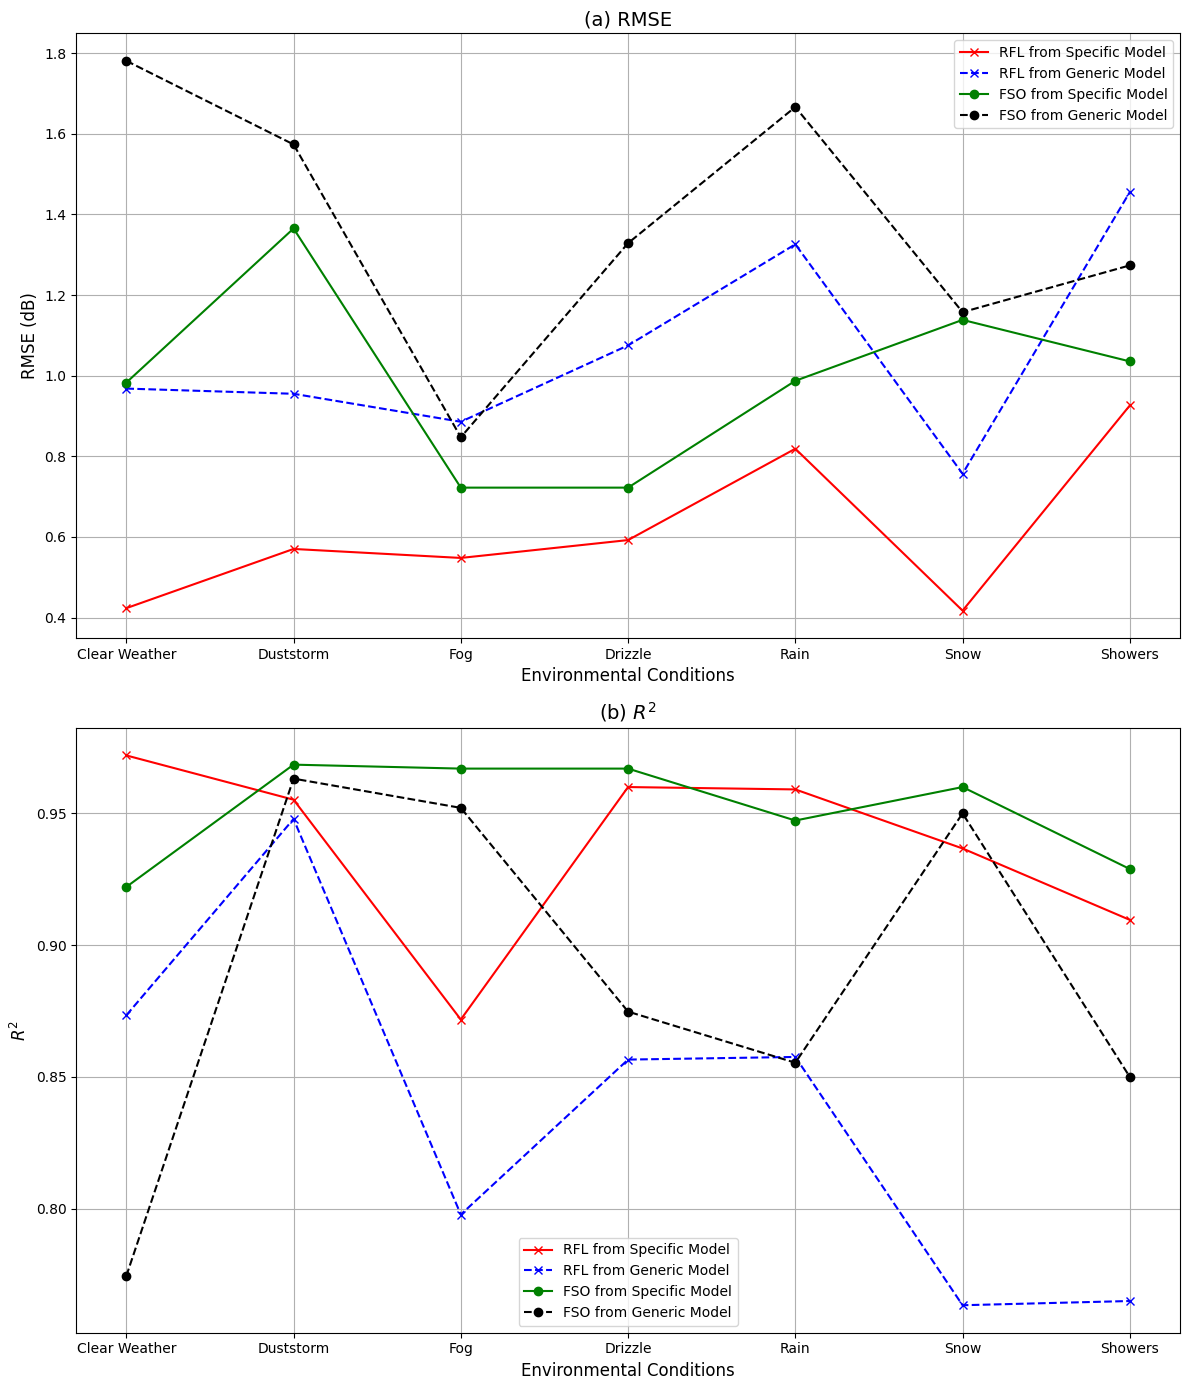

In [6]:
import matplotlib.pyplot as plt

rmse_rfl_specific = [0.4232, 0.5701, 0.5478, 0.5921, 0.8187, 0.4171, 0.9261]
r2_rfl_specific = [0.9720, 0.9552, 0.8718, 0.9600, 0.9591, 0.9367, 0.9096]
rmse_fso_specific = [0.9827, 1.3650, 0.7222, 0.7222, 0.9872, 1.1383, 1.0353]
r2_fso_specific = [0.9221, 0.9685, 0.9670, 0.9670, 0.9473, 0.9600, 0.9289]

rmse_rfl_generic = [0.9679, 0.955, 0.8856, 1.075, 1.3258, 0.7566, 1.4554]
r2_rfl_generic = [0.8734, 0.9479, 0.7978, 0.8566, 0.8576, 0.7634, 0.765]
rmse_fso_generic = [1.7809, 1.5735, 0.8472, 1.3286, 1.6664, 1.1575, 1.2735]
r2_fso_generic = [0.7745, 0.9632, 0.9521, 0.8748, 0.8554, 0.95, 0.85]

conditions = [
    "Clear Weather", "Duststorm", "Fog", "Drizzle", "Rain", "Snow", "Showers"
]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

ax1.plot(conditions, rmse_rfl_specific, '-x', label='RFL from Specific Model', color='red')
ax1.plot(conditions, rmse_rfl_generic, '--x', label='RFL from Generic Model', color='blue')
ax1.plot(conditions, rmse_fso_specific, '-o', label='FSO from Specific Model', color='green')
ax1.plot(conditions, rmse_fso_generic, '--o', label='FSO from Generic Model', color='black')
ax1.set_title('(a) RMSE', fontsize=14)
ax1.set_xlabel('Environmental Conditions', fontsize=12)
ax1.set_ylabel('RMSE (dB)', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(conditions, r2_rfl_specific, '-x', label='RFL from Specific Model', color='red')
ax2.plot(conditions, r2_rfl_generic, '--x', label='RFL from Generic Model', color='blue')
ax2.plot(conditions, r2_fso_specific, '-o', label='FSO from Specific Model', color='green')
ax2.plot(conditions, r2_fso_generic, '--o', label='FSO from Generic Model', color='black')
ax2.set_title(r'(b) $R^2$', fontsize=14)
ax2.set_xlabel('Environmental Conditions', fontsize=12)
ax2.set_ylabel(r'$R^2$', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
